# Qubit-data for Berillium Hydride

In [1]:
from mpi4py import MPI 
import netket as nk
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Preliminaries

The fermionic Hamiltonian in second quantization (with $M$ orbitals)

$$ H = \sum_{\alpha,\beta=1}^M t_{\alpha\beta}c^\dagger_\alpha c_\beta 
+ \frac{1}{2}\sum_{\alpha\beta=1}^M\sum_{\gamma\delta=1}^M u_{\alpha\beta\gamma\delta}c^\dagger_\alpha c^\dagger_\gamma c_\delta c_\beta$$

is mapped into a qubit Hamiltonian in the form

$$ H = \sum_kc_kP_k $$

where $c_k$ are interaction coefficients and $P_k$ are elements of the $N$-qubit Pauli group $\mathcal{P}_N=\{\mathbb{1},X,Y,Z\}^{\otimes N}$.

The interaction coefficients and the Pauli operators can be found in the `interaction.file` and the `pauli.file` respectively.

Specifics:
- Number of qubits: 6
- Molecule geometry: bond distance
- Fermionic basis: atomic STO-3G
- Qubit mapping: spin-parity + qubit tapering

 ## Neural-network reconstruction

In [2]:
# Identity 
I = np.asarray([[1.,0.],[0.,1.]])
# Pauli X
X = np.asarray([[0.,1.],[1.,0.]])
# Pauli Y
Y = np.asarray([[0.,-1j],[1j,0.]])
# Pauli Z
Z = np.asarray([[1.,0.],[0.,-1.]])

In [3]:
def operatorfromstring(pauli_string):
    """
    Generate a many-body operator from a list of single-qubit 
    pauli matrices.
    ---------------------------------------------------------
    Input    pauli_string: str , (ex: [X,Z,X,Y,...])
    
    Output   pauli_op: np.array, shape = [2**N,2**N]
    """
    op_list = []
    for k in range(len(pauli_string)):
        if (pauli_string[k] == 'X'):
            op_list.append(X)
        elif (pauli_string[k] == 'Y'):
            op_list.append(Y)
        elif (pauli_string[k] == 'Z'):
            op_list.append(Z)
        else:
            op_list.append(I)

    return reduce(np.kron,op_list)

def hamiltonian(pauli_list,interactions):
    """
    Generate a many-body hamiltonian
    ---------------------------------------------------------
    Input    pauli_list: list of pauli strings
             interactions: list of interaction strengths
    
    Output   hamiltonian: np.array, shape = [2**N,2**N]
    """
    N = len(pauli_list[0])
    hamiltonian = np.zeros((1<<N,1<<N),dtype=complex)
    for i,pauli in enumerate(pauli_list):
        hamiltonian += interactions[i]*operatorfromstring(pauli)
    return hamiltonian

def eigensolve(hamiltonian):
    """
    Compute ground state energy and wavefunction
    """
    (eigenvalues,eigenstates) = np.linalg.eigh(hamiltonian)
    return eigenvalues[0],eigenstates[:,0]

In [4]:
pauli_list   = np.load('../data/tomography/BeH2/paulis.file',allow_pickle=True)
interactions = np.load('../data/tomography/BeH2/interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIIIII  | Interaction: -1.707E+01
Pauli: ZIIIII  | Interaction: 1.156E-01
Pauli: XXZIII  | Interaction: 7.270E-03
Pauli: YYIIII  | Interaction: 7.270E-03
Pauli: ZZIIII  | Interaction: 1.000E-01
Pauli: ZXXIII  | Interaction: -4.618E-03
Pauli: IYYIII  | Interaction: -4.618E-03
Pauli: IZZIII  | Interaction: -1.599E-01
Pauli: IIZIII  | Interaction: -3.908E-01
Pauli: IIIZII  | Interaction: 1.156E-01
...


Quantum state reconstruction of the BeH2 ground state with a restricted Boltzmann machine, using the NetKet library.

References:
- _"Machine learning quantum states in the NISQ era"_ : review of quantum state reconstruction with restricted Boltzmann machines. https://arxiv.org/abs/1905.04312
- _"Precise measurement of quantum observables with neural-network estimators"_ RBM reconstruction of molecular ground states. https://arxiv.org/abs/1910.07596
- _"NetKet: A Machine Learning Toolkit for Many-Body Quantum Systems"_ Overview of the NetKet software library. https://arxiv.org/abs/1904.00031

In [5]:
# Unitary matrices for the rotation in the X and Y bases
rotationX = 1./(math.sqrt(2))*np.asarray([[1.,1.],[1.,-1.]])
rotationY= 1./(math.sqrt(2))*np.asarray([[1.,-1j],[1.,1j]])

def LoadData(N,hilbert,path_to_samples, path_to_bases):
    training_samples = []
    training_bases = []

    tsamples = np.loadtxt(path_to_samples)
    assert(N == tsamples.shape[1])
    fin_bases = open(path_to_bases, 'r')
    lines = fin_bases.readlines()

    bases = []

    for b in lines:
        basis = ""
        assert(len(b) == N + 1)
        for j in range(N):
            basis += b[j]
        bases.append(basis)
    index_list = sorted(range(len(bases)), key=lambda k: bases[k])
    bases.sort()

    for i in range(len(tsamples)):
        training_samples.append(tsamples[index_list[i]].tolist())

    rotations = []

    tmp = ''
    b_index = -1
    for b in bases:
        if (b != tmp):
            tmp = b
            localop = nk.operator.LocalOperator(hilbert, 1.0)

            for j in range(N):
                if (tmp[j] == 'X'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationX, [j])
                if (tmp[j] == 'Y'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationY, [j])

            rotations.append(localop)
            b_index += 1
        training_bases.append(b_index)

    return tuple(rotations), np.asarray(training_samples), np.asarray(training_bases)

def OperatorFromString(op_string):                                                
    OpList = []                                                                   
    Sites = []                                                                    
    for k in range(len(op_string)):                                               
        if (op_string[k] == 'X'):                                                 
            OpList.append(X)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Y'):                                               
            OpList.append(Y)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Z'):                                               
            OpList.append(Z)                                                      
            Sites.append(k)                                                       
    return Sites,reduce(np.kron,OpList) 

def BuildHamiltonian(N,hilbert,pauli_path,interactions_path):                     
    pauli = np.load(pauli_path,allow_pickle=True)                                 
    interactions = np.load(interactions_path,allow_pickle=True)                   
                                                                                  
    hamiltonian = nk.operator.LocalOperator(hilbert, 0.0)                                                                                 
    for h in range(0,len(pauli)):                                                                                           
        flag = 0                                                                  
        for j in range(N):                                                        
            if (pauli[h][j]!='I'): flag = 1; break                                
        if flag == 0:                                                             
            hamiltonian += nk.operator.LocalOperator(hilbert,np.real(interactions[h]))
        else:                                                                     
            sites,operator = OperatorFromString(pauli[h])                         
            h_term = interactions[h]*operator
            hamiltonian += nk.operator.LocalOperator(hilbert,h_term,sites)        
            
    return hamiltonian 

In [6]:
N = 6          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 10000     # Batch size
epochs = 200   # Epochs

samples_path = "../data/tomography/BeH2/train_samples.txt"
bases_path = "../data/tomography/BeH2/train_bases.txt"
pauli_path = "../data/tomography/BeH2/paulis.file"
interactions_path = "../data/tomography/BeH2/interactions.file"
ed_energy = float(np.loadtxt("../data/tomography/BeH2/energy.txt"))
psi0 = np.loadtxt("../data/tomography/BeH2/psi.txt")

In [7]:
# Lattice
graph = nk.graph.Hypercube(length=N, n_dim=1,pbc=False)
# Hilbert space
hilbert = nk.hilbert.Qubit(graph=graph)
# NetKet Hamiltonian
hamiltonian = BuildHamiltonian(N,hilbert,pauli_path,interactions_path)

In [8]:
# Load training data
rotations, tr_samples, tr_bases = LoadData(N,hilbert,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]

In [9]:
# RBM wavefunction
ma = nk.machine.RbmSpin(hilbert=hilbert, alpha=1)        # Complex-weights RBM, alpha=num_hidden/N
ma.init_random_parameters(seed=12345, sigma=0.01)

In [10]:
# Sampler
sa = nk.sampler.MetropolisLocal(machine=ma)

# Optimizer + Stochastic Reconfiguration
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR(diag_shift=0.1)

In [11]:
# Quantum state tomography object
qst = nk.Qsr(
    sampler=sa,
    optimizer=op,
    samples=training_samples,
    rotations=rotations,
    bases=training_bases,
    n_samples=M,
    n_samples_data=bs,
    sr=sr,
)
# Measure the energy while training
qst.add_observable(hamiltonian, "Energy")

# Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    # Get energy measurement
    obs = qst.get_observable_stats()
    # Compute overlap with exact state
    psima = ma.to_array()
    overlap = np.abs(np.vdot(psima, psi0))
    fidelity.append(overlap**2)
    rbm_energy = obs["Energy"].mean.real
    print('Epoch = %d   ' % ep,end='')
    print('Fidelity = %.6f   '% fidelity[-1],end='')
    print("<H> = %.8f" % rbm_energy,end=" | ")
    print("ED = %.8f" % ed_energy)

Epoch = 0   Fidelity = 0.013932   <H> = -16.91281302 | ED = -19.03879505
Epoch = 10   Fidelity = 0.019491   <H> = -16.97737903 | ED = -19.03879505
Epoch = 20   Fidelity = 0.040305   <H> = -17.20031879 | ED = -19.03879505
Epoch = 30   Fidelity = 0.084186   <H> = -17.46297049 | ED = -19.03879505
Epoch = 40   Fidelity = 0.170979   <H> = -17.78323176 | ED = -19.03879505
Epoch = 50   Fidelity = 0.315948   <H> = -18.09360681 | ED = -19.03879505
Epoch = 60   Fidelity = 0.504068   <H> = -18.37462153 | ED = -19.03879505
Epoch = 70   Fidelity = 0.698446   <H> = -18.61618218 | ED = -19.03879505
Epoch = 80   Fidelity = 0.841070   <H> = -18.83266994 | ED = -19.03879505
Epoch = 90   Fidelity = 0.912454   <H> = -18.91978809 | ED = -19.03879505
Epoch = 100   Fidelity = 0.944522   <H> = -18.96468585 | ED = -19.03879505
Epoch = 110   Fidelity = 0.957604   <H> = -18.97338749 | ED = -19.03879505
Epoch = 120   Fidelity = 0.960404   <H> = -18.97222571 | ED = -19.03879505
Epoch = 130   Fidelity = 0.966955   

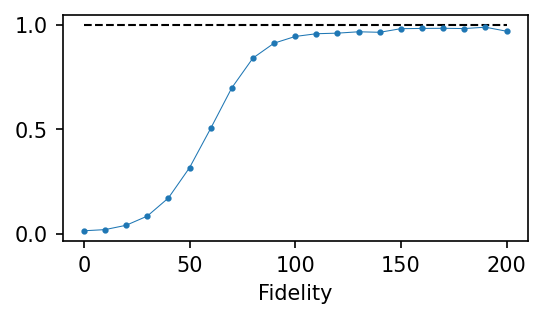

In [12]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Step",fontsize=10)
plt.xlabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20],[0,50,100,150,200],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 20,linewidth=1.0,linestyle="--")

plt.show()